# CNN Implementation for Sentiment Analysis on Amazon Product Reviews

# Prerequisites

The code blocks below can work perfectly with Google Colab. Colab allows anybody to write and execute arbitrary python code through the browser, and is especially well suited to machine learning, data analysis and education.

Incase you donot want to work on Colab, you can simply start from the heading "Importing Libraries", but you need to have train.ft.txt.bz2 and test.ft.txt.bz2 in the same directory.

# Downloading DATASET from Kaggle

Following steps are carried out in the code block below.

1. The dataset is downloaded from Kaggle, link is provided in the project proposal.

2. The user needs to upload a kaggle.jason which can be generated from the user's kaggle account.

In [28]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bittlingmayer/amazonreviews# CNN Implementation for Sentiment Analysis on Amazon Product Reviews# Downloading DATASET from Kaggle

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 491M/493M [00:03<00:00, 106MB/s]
100% 493M/493M [00:03<00:00, 131MB/s]


# Making a Directory and Unzipping files

Following steps are carried out in the code block below,

1. Making a new directory and calling it train in colab.

2. Unziping the file downloaded from kaggle into this directory.

In [29]:
! mkdir train
! unzip amazonreviews.zip -d train

Archive:  amazonreviews.zip
  inflating: train/test.ft.txt.bz2   
  inflating: train/train.ft.txt.bz2  


# Importing Libraries

Multiple libraries are included in the code block below, specially some tensorflow packages are imported for setting up CNN model, and some for converting the preprocessed data to a form which CNN model can understand. 

In [55]:
import pandas as pd 
import bz2 as bz
import csv
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, MaxPooling1D
from tensorflow.keras.layers import Conv1D, Embedding, GlobalMaxPooling1D
from tensorflow.keras.models import Model
import gc
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, roc_curve
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import SnowballStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Navigating to the directory with datasets

In [31]:
%cd /content/train

/content/train


# Data Formatting

Since the training dataset an testing dataset is already provided in seperate folders, they are processed using the following functions in the code block below.

1. The bz2 file is decompressed

2. .readlines() function returns a list, by reading each line of the file as a list item.

3. .decode() takes in the encoded string and returns the original string, list comprehension is used for clarity.

In [32]:
train_data = bz.BZ2File("train.ft.txt.bz2")
train_data = train_data.readlines()
train_data = [x.decode('utf-8') for x in train_data]


test_data = bz.BZ2File("test.ft.txt.bz2")
test_data = test_data.readlines()
test_data = [x.decode('utf-8') for x in test_data]

The datasets which are now in stored in lists are converted to pandas dataframes in the code block below and previous variables are deleted using 'del' operator, and gc.collect() is used to clear up the memory.

In [33]:
train_data_df = pd.DataFrame(train_data)
del train_data
test_data_df = pd.DataFrame(test_data)
del test_data

A column name is assigned to both dataframes i.e. one with training data and one with test data.

Dataframe corresponding to test data is shown in the output. It has 400k rows, and just for information the training dataframe has 3.6M rows.

In [34]:
train_data_df.rename(columns={0: 'String'},inplace=True)
train_data_df.dropna()

test_data_df.rename(columns={0: 'String'},inplace=True)
test_data_df.dropna()

,String
0,__label__2 Great CD: My lovely Pat has one of ...
1,__label__2 One of the best game music soundtra...
2,__label__1 Batteries died within a year ...: I...
3,"__label__2 works fine, but Maha Energy is bett..."
4,__label__2 Great for the non-audiophile: Revie...
...,...
399995,__label__1 Unbelievable- In a Bad Way: We boug...
399996,"__label__1 Almost Great, Until it Broke...: My..."
399997,__label__1 Disappointed !!!: I bought this toy...
399998,__label__2 Classic Jessica Mitford: This is a ...


Following steps will be done in the code block below.

1. After looking at the dataset it can observed that we need to make a split each cell of the Column 'String', this needs to done inorder to split the "LABELS" from "REVIEWS".

2. Considering the above information 2 more columns are added to the above dataframes (train and test both). These columns are created by making a split at the first space (" "), in the string, by using str.split() function.

3. The del operator is used to delete the String Column as we donot need it anymore

4. The labels are mentioned in a specific format, for ease of processing we will just binarize the labels, as in

=> 0 = "label1" : Negative Review

=> 1 = "label2" : Positive Review

In [35]:
train_data_df[['Label','Review']] = train_data_df.String.str.split(" ",expand=True,n = 1)
del train_data_df["String"]
train_data_df = train_data_df.replace({'Label': {'__label__1': 0, '__label__2': 1}})

test_data_df[['Label','Review']] = test_data_df.String.str.split(" ",expand=True,n = 1)
del test_data_df["String"]
test_data_df = test_data_df.replace({'Label': {'__label__1': 0, '__label__2': 1}})

In [36]:
test_data_df.head()

,Label,Review
0,1,Great CD: My lovely Pat has one of the GREAT v...
1,1,One of the best game music soundtracks - for a...
2,0,Batteries died within a year ...: I bought thi...
3,1,"works fine, but Maha Energy is better: Check o..."
4,1,Great for the non-audiophile: Reviewed quite a...


In [37]:
train_data_df.head()

,Label,Review
0,1,Stuning even for the non-gamer: This sound tra...
1,1,The best soundtrack ever to anything.: I'm rea...
2,1,Amazing!: This soundtrack is my favorite music...
3,1,Excellent Soundtrack: I truly like this soundt...
4,1,"Remember, Pull Your Jaw Off The Floor After He..."


# Feature Engineering

### Cleaning and Stemming

In the code block below, cleanText() is defined to perform the preprocessing on the raw data, this function does the following tasks,

1. Removes Punctuation.

2. Removes Stopwords.

3. Performs stemming.

and What is Stemming ?

Stemming is the process of reducing inflected (or sometimes derived) words to their word stem, base or root form—generally a written word form. The stem need not be identical to the morphological root of the word; it is usually sufficient that related words map to the same stem, even if this stem is not in itself a valid root.

In [38]:
# Fetch stopwords from NTLK and stemming
word_stemmer = SnowballStemmer("english", ignore_stopwords=False)

# Creating a set of stopwords
stopWords = set([word for word in set(stopwords.words('english'))])

# Defining a function to clean up the text (removing new line symbols etc)
def cleanText(text):
    """
    Input: Unprocessed Data, containing punctuation, stopwords etc. i.e. Column with Reviews
    Output: Processed data, with useless information stripped off.
    """
    
    text = text.replace('\n', ' ').strip().lower()
    # Remove any symbols
    text = re.sub(r'[^a-zæøåéäö ]+', '', text)
    # Remove consecutive whitespaces
    text = re.sub(r'\s\s+', ' ', text)
    # Removing stopwords in the text and stemming the words. 
    text = ' '.join([word_stemmer.stem(word) for word in text.split()
                     if word not in stopWords])
    return text

In [39]:
train_data_df.Review = [cleanText(str(r)) if str(r) != 'nan' else '' for r in train_data_df.Review]  

In [40]:
train_data_df.head()

,Label,Review
0,1,stune even nongam sound track beauti paint sen...
1,1,best soundtrack ever anyth im read lot review ...
2,1,amaz soundtrack favorit music time hand intens...
3,1,excel soundtrack truli like soundtrack enjoy v...
4,1,rememb pull jaw floor hear youv play game know...


In [41]:
test_data_df.Review = [cleanText(str(r)) if str(r) != 'nan' else '' for r in test_data_df.Review]

In [42]:
test_data_df.tail()

,Label,Review
399995,0,unbeliev bad way bought thoma son huge thoma f...
399996,0,almost great broke son reciev birthday gift mo...
399997,0,disappoint bought toy son love thoma toy need ...
399998,1,classic jessica mitford compil wide rang mitfo...
399999,0,comedi scene heard dvd disappoint get hope see...


### Tokenization

Looking at the dataframe above we can still make some sense out of it after stemming, but we have to convert our data into a form which can be processed by our LSTM model. This process is called tokenization, there is a TensorFlow api for doing this process.

We will discuss tokenization process briefly below, with some images and examples learned from TensorFlow channel on YouTube.

Lets take an example, we want to encode a sentence, "I love my dog".

We can simply do the following simple encoding for this process.

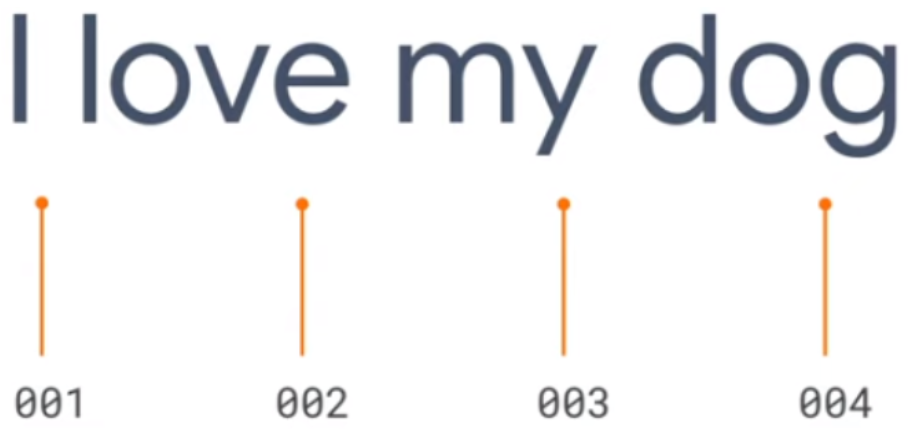

We just assigned 1,2,3,4 to the words in the sentence *"I love my dog"* sequentially. Lets say we have another sentence. "I love my cat".

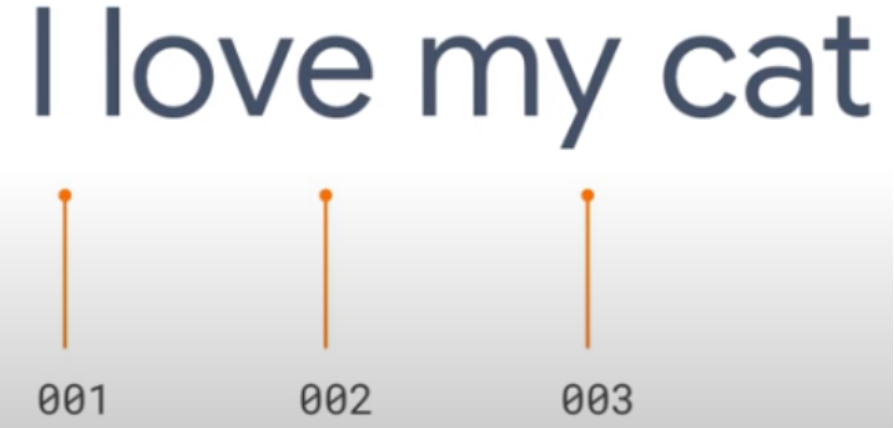

It can be seen the first 3 words were already, encoded earlier, we can just need to encode the last word, as done below.

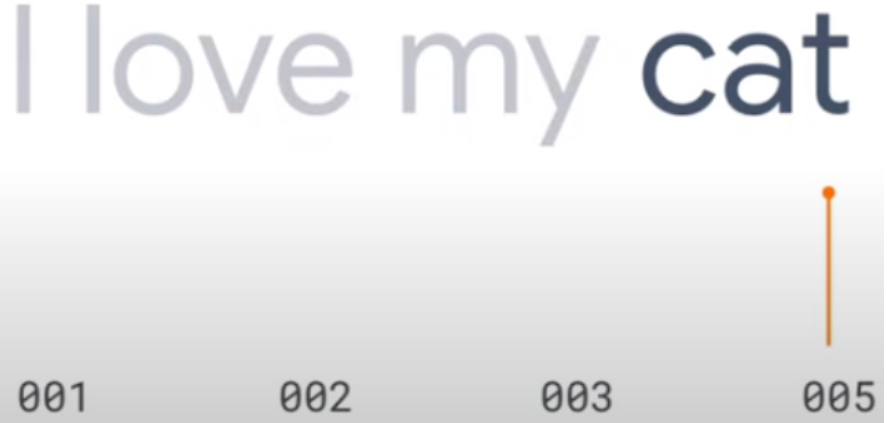

Now if we look at the two sentences, they are represented as,

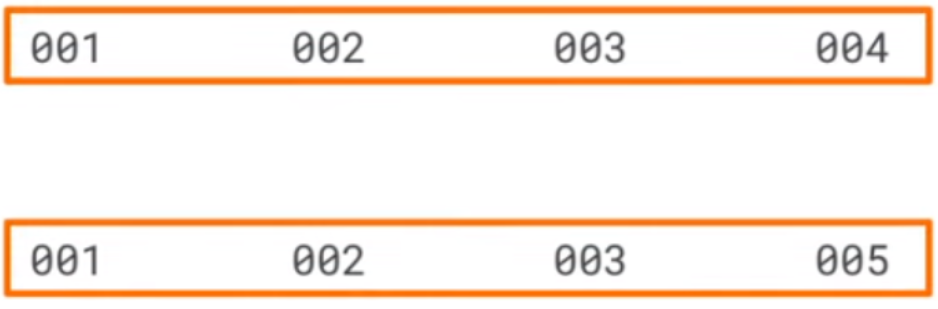

We can already, see some kind of similarity in the sentences after the encoding, because oth sentences are about loving a pet.

Keeping this in mind, lets explain the tokenization process by looking at the code below.

Tokenizer is a imported from tensorflow.keras.preprocessing.text.Tokenizer, it is a text tokenization utility class in keras.

Following steps are completed in the code block below,

1. A Tokenizer class instance named tokenizer is created, with num_words set to 20000, this represents the maximum number of words to keep in tokenization process. Imagine we had a a huge array of sentences, as we do have in this case (3.6 Million reviews for training the network), instead just the two examples discussed above.

**Simply, this will just give us the most frequent 20,000 words in that list of 3.6M reviews, after we do the next step.**

2. tokenizer.fit_on_texts is used to update internal vocabulary based on a list of texts in the case where texts contains lists, we assume each entry of the lists to be a token. The tokenizer is smart enough to overcome small issues, as shown below,

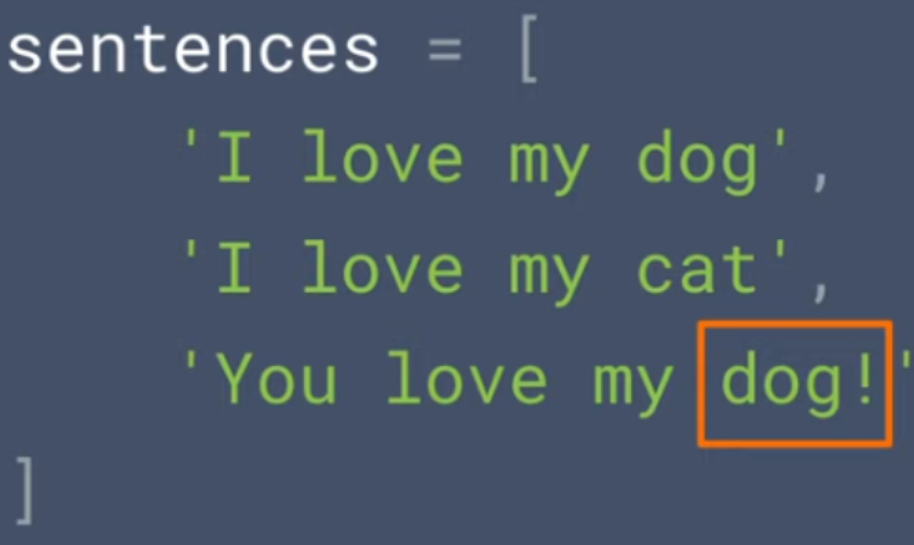

The tokenizer, does not creates a new object for dog!, same one is assigned for dog and dog! both. The result can be seen below as there is not token for dog! but their is one for dog.

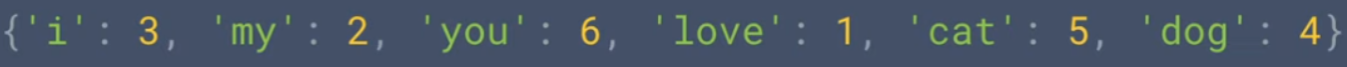

3. In the last steps, our tokenization process was completed. Now we will convert these numbers into ordered sequences then our data will be ready to sent as input to our Neural Network.

4. tokenizer.texts_to_sequences is used to create sequences of tokens representing each sentence. For elaboration consider the following sentences,

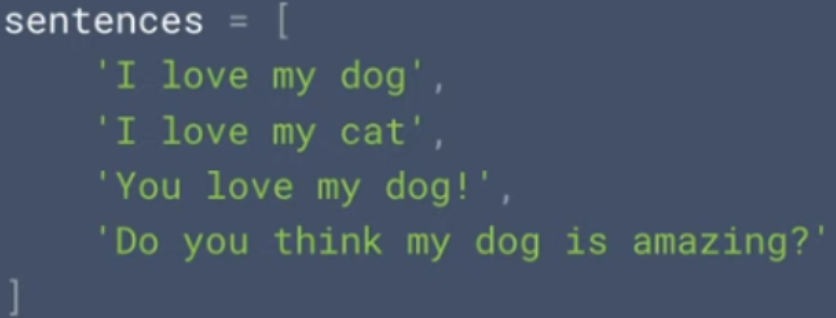

These sentences are converted to word-values pairs in a dictionary using tokenizer.fit_on_texts, this dictionary can be visualized by tokenizer.word_index. The dictionary can be seen below.

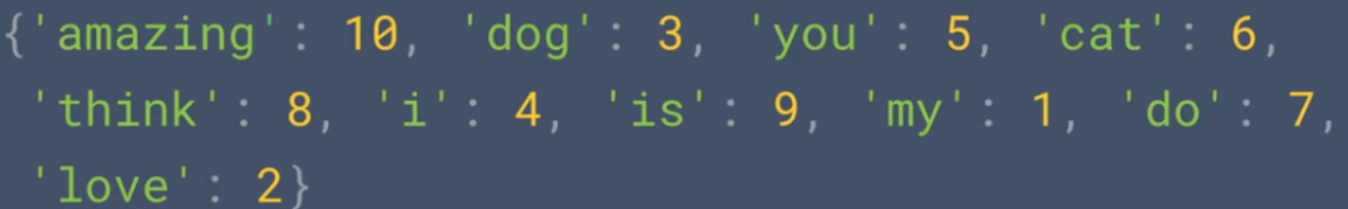

After performing, tokenizer.texts_to_sequences on the above example, following results are obtained..

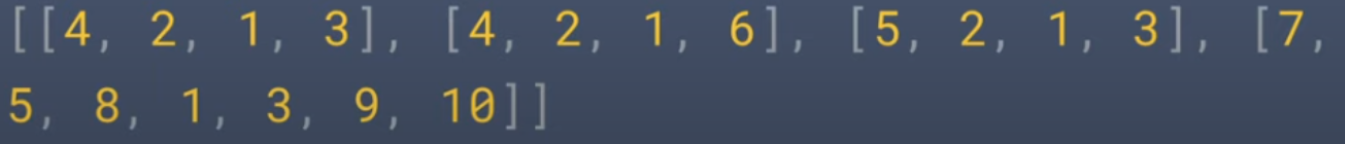

These results can be further elaborated by following the arrows in the figure below, the first sequence makes up the first sentence, meaning "I love my dog".

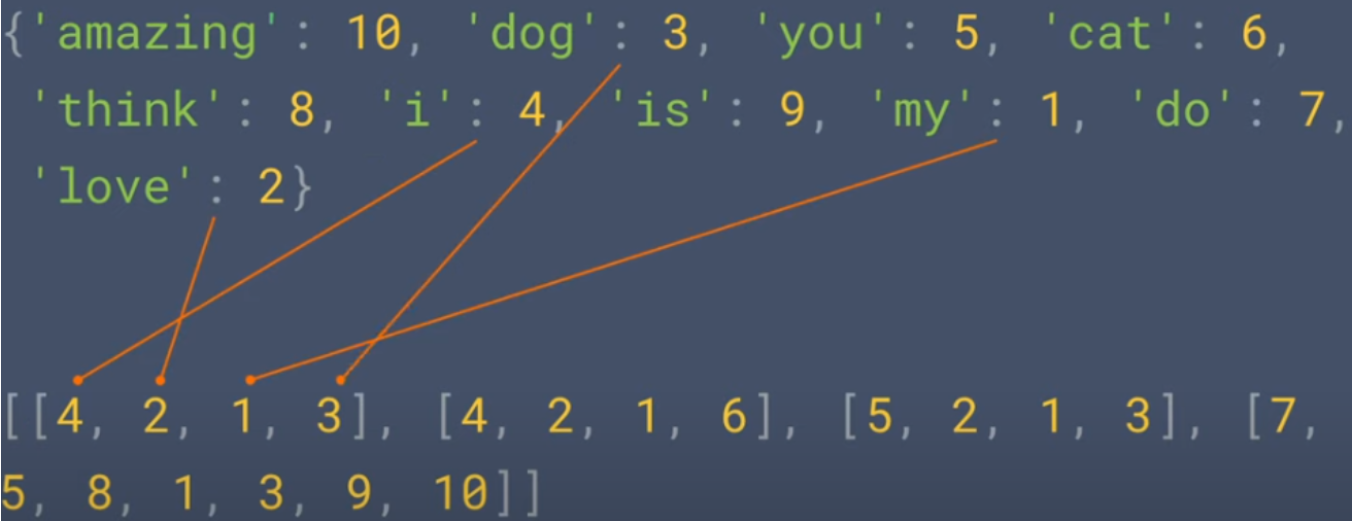

5. The sequencing operation is performed on both training data and test data.

An important parameter in initialization of Tokenizer instance was oov_token, this is the out of vocabulary token, now since we show only the training data to our tokenizer, while building vocabulary, we make an additional token for out of vocabulary words.

In [43]:
tokenizer = Tokenizer(num_words = 20000, oov_token = "<OOV>")
tokenizer.fit_on_texts(train_data_df.Review)

sequences_train = tokenizer.texts_to_sequences(train_data_df.Review)

sequences_test = tokenizer.texts_to_sequences(test_data_df.Review)

The full list of words kept by tokenizer is available as tokenzer's index property. The result will be of type dictionary, with key = word and value being the token.

For example, after running this on "I love my dog", we may get,

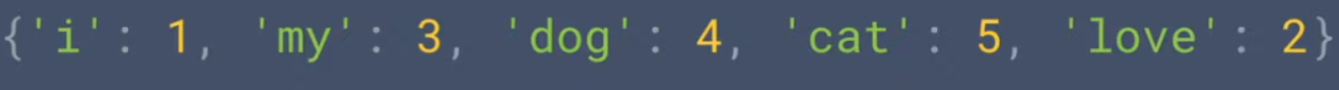

The number of unique tokens in dataset are shown below, i.e. 1103004. 

In [44]:
word2idx = tokenizer.word_index
V = len(word2idx)
print('Found %s unique tokens.' % V)

Found 1870614 unique tokens.


Taking our labels from training and test data

In [45]:
Y_test  = test_data_df['Label'].values
Y_train = train_data_df['Label'].values

Deletng the old dataframes from memory and old instances, they have served their purpose.

In [46]:
del tokenizer 
del  train_data_df
del test_data_df


In [47]:
gc.collect()

0

One may question the fact, that how will we handle the sentences of diifferent lengths, because naturally all the reviews will be of different lengths as they are made by different people regarding different products on amazon.

We will use pad_sequences which basically adds zero's infront of the sequence to make all sequence lengths equal to the maximum length (i.e. which is the length of the biggest review).

This padding can be done infront of the sequence, or after or the user can also define the maximum length and truncate the remaining encoded words.

In [48]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print('Shape of data train tensor:', data_train.shape)

# get sequence length
T = data_train.shape[1]
del sequences_train
gc.collect()

Shape of data train tensor: (3600000, 185)


0

Similar padding step is done for test data, the maxlen is defined to keep the dimensions same as training data.

In [49]:
data_test = pad_sequences(sequences_test, maxlen=T)
print('Shape of data test tensor:', data_test.shape)
del sequences_test
gc.collect()

Shape of data test tensor: (400000, 185)


0

### Word Embedding Process by using Keras Embedding Layer

Word embeddings are a type of word representation that allows words with similar meaning to have a similar representation. They are an improvement over sparse representations used in simpler bag of word model representations. Word embeddings can be learned from text data and reused among projects. They can also be learned as part of fitting a neural network on text data, and this approach is used below in Model selection.

An embedding layer, for lack of a better name, is a word embedding that is learned jointly with a neural network model on a specific natural language processing task, such as language modeling or document classification.

It requires that document text be cleaned and prepared such that each word is one-hot encoded. The size of the vector space is specified as part of the model, such as 50, 100, or 300 dimensions. The vectors are initialized with small random numbers. The embedding layer is used on the front end of a neural network and is fit in a supervised way using the Backpropagation algorithm.

When the input to a neural network contains symbolic categorical features (e.g. features that take one of k distinct symbols, such as words from a closed vocabulary), it is common to associate each possible feature value (i.e., each word in the vocabulary) with a d-dimensional vector for some d. These vectors are then considered parameters of the model, and are trained jointly with the other parameters.

This approach of learning an embedding layer requires a lot of training data and can be slow, but will learn an embedding both targeted to the specific text data and the NLP task.

# Model Initialization

In the code block below, we have defined hyper parameters for the CNN model.

1. **Input()**, is used to initiate a Keras Tensor.

A Keras tensor is a TensorFlow symbolic tensor object, which we augment with certain attributes that allow us to build a Keras model just by knowing the inputs and outputs of the model.

A shape tuple (integers), not including the batch size. For instance, shape=(T,) indicates that the expected input will be batches of T-dimensional vectors. Elements of this tuple can be None; 'None' elements represent dimensions where the shape is not known. T is equal to 257.

2. The **embedding layer** requires 3 parameters, input_dim, output_dim and input_length.

*input_dim* = size of vocabulary of data, i.e. number of unique tokens + 1, here V+1.

*output_dim* = This is the size of the vector space in which words are embedded, it defines the size of the output vectors for each word, if this number is too high (lets say 100), it can cause a memory crash in Google Colab. Here is it defined as D (i.e. = 20).

*input_length* = Length of input sequences, when it is constant here i.e. 257. This argument is required if you are going to connect Flatten then Dense layers upstream.

3. **Convolution Layer**, tensorflow.keras.Conv1D is used to perform temporal convolution. 

Convolutions are sliding window functions applied to a matrix that achieve specific results (e. g., image blur, edge detection.) The sliding window is called a kernel, filter, or feature detector. A 1D convolution layer creates a convolution kernel that passes over a single spatial (or temporal) dimension to produce a tensor of outputs

Two parameters are set in the initialization of COV1d below, 

i. Filters = 32 (Sets the number of output filters used in the convolution operation)

ii. kernel_size = 3 (Specifies the size of the convolutional window)

A 1D CNN is very effective for deriving features from a fixed-length segment of the overall dataset, where it is not so important where the feature is located in the segment. Where as LSTMS, take into account the proximity of words to create trainable patterns.

4. **Dropout* Layer**, used for dropout reglarization, dropout rate is specified.  

The dropout rate can be specified to the layer as the probability of setting each input to the layer to zero.

5. **MaxPooling1D() Layer**, max pooling operation for 1D temporal data, downsamples input representation, by taking the maximum value over the defined window. 

6. **Dense layer** is nothing but a regular fully-connected NN layer. In this case we are bringing down the output dimensionality to 1.

In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20
#We assign dropout rate
dropout_rate = 0.2

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(dropout_rate)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)


# Fitting Model and Evaluation

The model.compile is used to setup the compilation parameters, such as optimizer and metrics.

### Epochs:

The number of epochs is a hyperparameter that defines the number of times that the learning algorithm will work through the entire training dataset. The number of epochs can be set to an integer value between one and infinity. You can run the algorithm for as long as you like and even stop it using other criteria besides a fixed number of epochs, such as a change (or lack of change) in model error over time.

### BatchSize:

The batch size is a number of samples processed before the model is updated. The size of a batch must be more than or equal to one and less than or equal to the number of samples in the training dataset.

## Model 1 - Dropout_rate = 0.2, before Conv1D, batchsize = 9216



In [ ]:
# Compile and fit
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
r = model.fit(
  data_train,
  Y_train,
  epochs=5,batch_size=9216,
  validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
391/391 [==============================] - 1328s 3s/step - loss: 0.3303 - accuracy: 0.8499 - val_loss: 0.2711 - val_accuracy: 0.8869
Epoch 2/5
391/391 [==============================] - 1327s 3s/step - loss: 0.2664 - accuracy: 0.8891 - val_loss: 0.2588 - val_accuracy: 0.8926
Epoch 3/5
391/391 [==============================] - 1324s 3s/step - loss: 0.2565 - accuracy: 0.8938 - val_loss: 0.2561 - val_accuracy: 0.8936
Epoch 4/5
391/391 [==============================] - 1323s 3s/step - loss: 0.2498 - accuracy: 0.8971 - val_loss: 0.2576 - val_accuracy: 0.8932
Epoch 5/5
391/391 [==============================] - 1322s 3s/step - loss: 0.2449 - accuracy: 0.8992 - val_loss: 0.2558 - val_accuracy: 0.8939


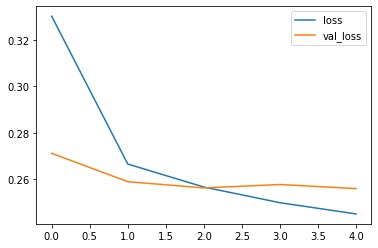

In [ ]:
plt.plot(r.history['loss'],label = 'loss')
plt.plot(r.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

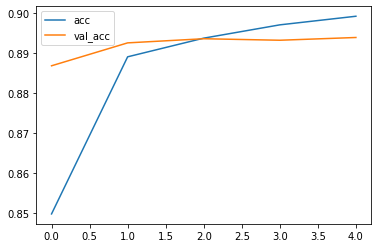

In [ ]:
plt.plot(r.history['accuracy'],label = 'acc')
plt.plot(r.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [ ]:
test_l,test_acc = model.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 65s 5ms/step - loss: 0.2558 - accuracy: 0.8939
0.2558453679084778 is the Test Loss and  0.8939250111579895 is the test accuracy


## Model 2 - Dropout_rate = 0.2, before Conv1D, batchsize = 3072

In [ ]:
# Create the model

# We get to choose embedding dimensionality
D = 20
#We assign dropout rate
dropout_rate = 0.2

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(dropout_rate)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(i, x)


In [ ]:
# Compile and fit
model2.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
History = model2.fit(
  data_train,
  Y_train,
  epochs=5,batch_size=3072,
  validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
1172/1172 [==============================] - 1613s 1s/step - loss: 0.2999 - accuracy: 0.8686 - val_loss: 0.2699 - val_accuracy: 0.8863
Epoch 2/5
1172/1172 [==============================] - 1609s 1s/step - loss: 0.2568 - accuracy: 0.8934 - val_loss: 0.2541 - val_accuracy: 0.8938
Epoch 3/5
1172/1172 [==============================] - 1610s 1s/step - loss: 0.2477 - accuracy: 0.8977 - val_loss: 0.2477 - val_accuracy: 0.8971
Epoch 4/5
1172/1172 [==============================] - 1616s 1s/step - loss: 0.2417 - accuracy: 0.9005 - val_loss: 0.2520 - val_accuracy: 0.8952
Epoch 5/5
1172/1172 [==============================] - 1617s 1s/step - loss: 0.2371 - accuracy: 0.9027 - val_loss: 0.2480 - val_accuracy: 0.8972


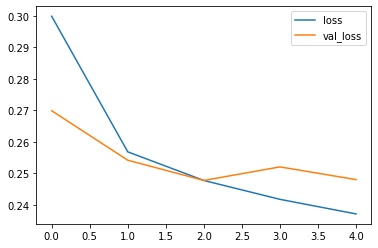

In [ ]:
plt.plot(History.history['loss'],label = 'loss')
plt.plot(History.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

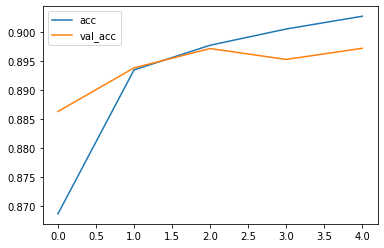

In [ ]:
plt.plot(History.history['accuracy'],label = 'acc')
plt.plot(History.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [ ]:
test_l,test_acc = model2.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 66s 5ms/step - loss: 0.2480 - accuracy: 0.8972
0.24797704815864563 is the Test Loss and  0.8971549868583679 is the test accuracy


## Model 3 - Dropout_rate = 0.1, After Conv1D, batchsize = 3072

In [59]:
# Create the model

# We get to choose embedding dimensionality
D = 20
#We assign dropout rate
dropout_rate = 0.1

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(1, activation='sigmoid')(x)

model3 = Model(i, x)

In [60]:
# Compile and fit
model3.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
History2 = model3.fit(
  data_train,
  Y_train,
  epochs=5,batch_size=3072,
  validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
1172/1172 [==============================] - 1560s 1s/step - loss: 0.2886 - accuracy: 0.8750 - val_loss: 0.2558 - val_accuracy: 0.8939
Epoch 2/5
1172/1172 [==============================] - 1515s 1s/step - loss: 0.2442 - accuracy: 0.8997 - val_loss: 0.2451 - val_accuracy: 0.8988
Epoch 3/5
1172/1172 [==============================] - 1488s 1s/step - loss: 0.2306 - accuracy: 0.9062 - val_loss: 0.2425 - val_accuracy: 0.9000
Epoch 4/5
1172/1172 [==============================] - 1461s 1s/step - loss: 0.2212 - accuracy: 0.9105 - val_loss: 0.2419 - val_accuracy: 0.9008
Epoch 5/5
1172/1172 [==============================] - 1454s 1s/step - loss: 0.2138 - accuracy: 0.9141 - val_loss: 0.2433 - val_accuracy: 0.8996


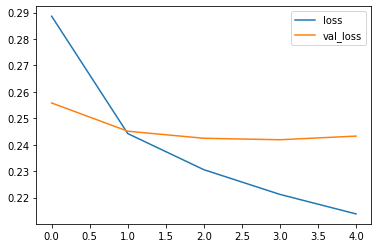

In [61]:
plt.plot(History2.history['loss'],label = 'loss')
plt.plot(History2.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

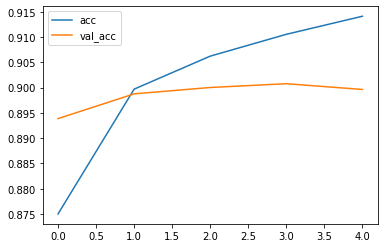

In [62]:
plt.plot(History2.history['accuracy'],label = 'acc')
plt.plot(History2.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [63]:
test_l,test_acc = model3.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 76s 6ms/step - loss: 0.2433 - accuracy: 0.8996
0.24328401684761047 is the Test Loss and  0.899619996547699 is the test accuracy


## Model 4 - Dropout_rate = 0.1, before Conv1D, batchsize = 3072



In [64]:
# Create the model

# We get to choose embedding dimensionality
D = 20
#We assign dropout rate
dropout_rate = 0.1

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Dropout(dropout_rate)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model4 = Model(i, x)


In [65]:
# Compile and fit
model4.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
History4 = model4.fit(
  data_train,
  Y_train,
  epochs=5,batch_size=3072,
  validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
1172/1172 [==============================] - 1635s 1s/step - loss: 0.2933 - accuracy: 0.8726 - val_loss: 0.2605 - val_accuracy: 0.8916
Epoch 2/5
1172/1172 [==============================] - 1647s 1s/step - loss: 0.2520 - accuracy: 0.8958 - val_loss: 0.2475 - val_accuracy: 0.8975
Epoch 3/5
1172/1172 [==============================] - 1639s 1s/step - loss: 0.2403 - accuracy: 0.9014 - val_loss: 0.2487 - val_accuracy: 0.8970
Epoch 4/5
1172/1172 [==============================] - 1649s 1s/step - loss: 0.2325 - accuracy: 0.9051 - val_loss: 0.2406 - val_accuracy: 0.9008
Epoch 5/5
1172/1172 [==============================] - 1667s 1s/step - loss: 0.2267 - accuracy: 0.9076 - val_loss: 0.2394 - val_accuracy: 0.9014


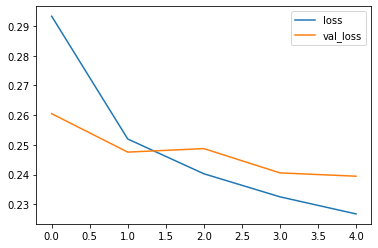

In [66]:
plt.plot(History4.history['loss'],label = 'loss')
plt.plot(History4.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

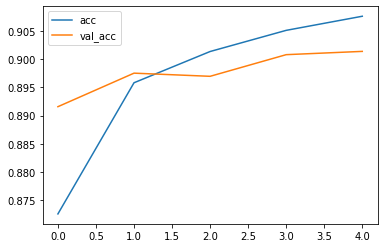

In [67]:
plt.plot(History4.history['accuracy'],label = 'acc')
plt.plot(History4.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [68]:
test_l,test_acc = model4.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 71s 6ms/step - loss: 0.2394 - accuracy: 0.9014
0.23943175375461578 is the Test Loss and  0.9014074802398682 is the test accuracy


## Model 5 - Dropout_rate = 0.1, after Conv1D, batchsize = 9216

In [25]:
# Create the model

# We get to choose embedding dimensionality
D = 20
#We assign dropout rate
dropout_rate = 0.1

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(1, activation='sigmoid')(x)

model5 = Model(i, x)

In [26]:
# Compile and fit
model5.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


print('Training model...')
History5 = model5.fit(
  data_train,
  Y_train,
  epochs=5,batch_size=9216,
  validation_data=(data_test, Y_test)
)

Training model...
Epoch 1/5
391/391 [==============================] - 1164s 3s/step - loss: 0.3254 - accuracy: 0.8525 - val_loss: 0.2683 - val_accuracy: 0.8879
Epoch 2/5
391/391 [==============================] - 1164s 3s/step - loss: 0.2574 - accuracy: 0.8934 - val_loss: 0.2552 - val_accuracy: 0.8937
Epoch 3/5
391/391 [==============================] - 1169s 3s/step - loss: 0.2430 - accuracy: 0.9004 - val_loss: 0.2493 - val_accuracy: 0.8962
Epoch 4/5
391/391 [==============================] - 1170s 3s/step - loss: 0.2329 - accuracy: 0.9053 - val_loss: 0.2466 - val_accuracy: 0.8978
Epoch 5/5
391/391 [==============================] - 1168s 3s/step - loss: 0.2251 - accuracy: 0.9090 - val_loss: 0.2472 - val_accuracy: 0.8980


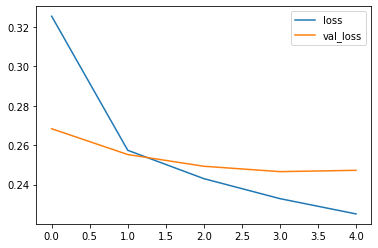

In [27]:
plt.plot(History5.history['loss'],label = 'loss')
plt.plot(History5.history['val_loss'],label = 'val_loss')
plt.legend()
plt.show()

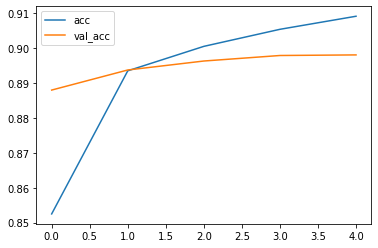

In [28]:
plt.plot(History5.history['accuracy'],label = 'acc')
plt.plot(History5.history['val_accuracy'],label = 'val_acc')
plt.legend()
plt.show()

In [73]:
test_l,test_acc = model5.evaluate(data_test, Y_test)
print(test_l, "is the Test Loss and ", test_acc, "is the test accuracy")

12500/12500 [==============================] - 67s 5ms/step - loss: 0.2455 - accuracy: 0.8991
0.24551905691623688 is the Test Loss and  0.8990625143051147 is the test accuracy


# Concluding Remarks

1-D Convolution Neural Network, is effective for NLP application but LSTMs are still a little better as they have the ability to take into account the proximity of words to create trainable patterns. Multiple attempts have been made on improving the the performace from CNNs, by changing dropout ratio, location of dropout layer and batch size. 

**Model 4, seems to out-perform all other CNN models**, in model 4 dropout_rate = 0.1, dropout layer is before before Conv1D, and batchsize = 3072. The test accuracy in Model 4 is **90.14 %**, which is very good. 

# References

Convolution Neural Networks -1D, 
1. https://missinglink.ai/guides/keras/keras-conv1d-working-1d-convolutional-neural-networks-keras/

TensorFlow Youtube Channel

2. https://www.youtube.com/channel/UC0rqucBdTuFTjJiefW5t-IQ

Use Word Embeddings layers in Deep Learning

3. https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

What are word embeddings ?

4. https://machinelearningmastery.com/what-are-word-embeddings/

— Page 49, Neural Network Methods in Natural Language Processing, 2017,

5. https://amazon.com/Language-Processing-Synthesis-Lectures-Technologies/dp/1627052984/ref=as_li_ss_tl?ie=UTF8&qid=1502062931&sr=8-1&keywords=Neural+Network+Methods+in+Natural+Language+Processing&linkCode=sl1&tag=inspiredalgor-20&linkId=d63df073fea3ebe2d405820570b3ff03